# Spam Classification using BERT

This notebook details part two of the CA4023 assignment 2. This requires the use of the transformer language model BERT which was developed by Google in 2018 (Devlin et al. 2018). This notebook undertakes the third option in this assignment which is fine tuning BERT on another dataset. The selected task is spam classification. This spam classification is on the sms messages dataset. The dataset is available from HuggingFace [here](https://huggingface.co/datasets/sms_spam)

The Hugging face dataset library is installed 

In [1]:
pip install datasets

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 134 kB 45.8 MB/s 
     |████████████████████████████████| 1.1 MB 44.3 MB/s 
     |████████████████████████████████| 67 kB 5.6 MB/s 
     |████████████████████████████████| 212 kB 47.0 MB/s 
     |████████████████████████████████| 127 kB 43.9 MB/s 
     |████████████████████████████████| 144 kB 48.0 MB/s 
     |████████████████████████████████| 271 kB 43.1 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


The HuggingFace transformers library is also installed


In [2]:
pip install transformers

     |████████████████████████████████| 3.8 MB 5.3 MB/s 
     |████████████████████████████████| 6.5 MB 33.6 MB/s 
     |████████████████████████████████| 895 kB 42.5 MB/s 
     |████████████████████████████████| 596 kB 33.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


The spam dataset is loaded into this notebook.


In [3]:
from datasets import load_dataset

spam_data = load_dataset("sms_spam")

Generating train split:   0%|          | 0/5574 [00:00<?, ? examples/s]

Dataset sms_spam downloaded and prepared to /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

## Inspection of the data

The data set is a collection of labels and sms text. This is inspected below to get a greater understanding of what data we are dealing with.

In [4]:
spam_data.keys()

dict_keys(['train'])

In [30]:
for v in range(5):
  print(str(spam_data['train'][v]) + '\n')

{'sms': 'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...\n', 'label': 0}

{'sms': 'Ok lar... Joking wif u oni...\n', 'label': 0}

{'sms': "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's\n", 'label': 1}

{'sms': 'U dun say so early hor... U c already then say...\n', 'label': 0}

{'sms': "Nah I don't think he goes to usf, he lives around here though\n", 'label': 0}



In [53]:
print("There are: " + str(len(spam_data['train'])) + " sms in the dataset")
count = 0
i = 0
while i < len(spam_data['train']):
  sms_label = spam_data['train'][i]['label']
  if sms_label == 1:
    count += 1
  i += 1

print(str(count) +' of these sms are spam')

There are: 5574 sms in the dataset
747 of these sms are spam


The data set contains 5,574 sms messages and a corresponding label for each of these. There are 747 spam sms messages and 4,827 ham sms messages. The language used in these texts varies but it can be seen that there is the use of slang and abbreaviation across spam and ham sms. This may provide a challenge for the BERT model

The data set is split 80/20 into a training and testing set. 4,400 entries are used for training and 1,100 entries for testing. The data is shuffled for random selection.

In [7]:
train_data = spam_data['train'].shuffle(seed=42).select(range(4400))
test_data = spam_data['train'].shuffle(seed=42).select(range(4400,5500))
print(len(train_data))
print(len(test_data))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/sms_spam/plain_text/1.0.0/53f051d3b5f62d99d61792c91acefe4f1577ad3e4c216fb0ad39e30b9f20019c/cache-432f7f85ecf57ba0.arrow


4400
1100


Instantiate the model


In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Tokenize the data into an appropriate form for the model

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_dataset(dataset,tokenizer):
  tokenized_dataset = []
  for item in dataset:
    tokenized = tokenizer(item["sms"],padding="max_length", truncation=True)
    item.update(tokenized)
    tokenized_dataset.append(item)
  return tokenized_dataset

tokenized_train = tokenize_dataset(train_data,tokenizer)
tokenized_test = tokenize_dataset(test_data,tokenizer)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [10]:
from transformers import TrainingArguments

training_args = TrainingArguments("test_trainer",evaluation_strategy="epoch")

Create a function for evaluation of the model

In [11]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric = load_metric("accuracy")
    return metric.compute(predictions=predictions, references=labels)

Pass the model, training arguments, tokenized test and train data, and the required evaluation parameters into the trainer class.

In [12]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    args=training_args, 
    train_dataset=tokenized_train, 
    eval_dataset=tokenized_test,
    compute_metrics = compute_metrics
)

Fine tune the BERT model on the sms spam dataset

In [13]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4400
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1650


Epoch,Training Loss,Validation Loss,Accuracy
1,0.092800,0.041809,0.991818
2,0.036700,0.034608,0.993636
3,0.012100,0.044008,0.992727


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1100
  Batch size = 8


Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1100
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1100
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1650, training_loss=0.04371812805984959, metrics={'train_runtime': 2681.6032, 'train_samples_per_second': 4.922, 'train_steps_per_second': 0.615, 'total_flos': 3473065930752000.0, 'train_loss': 0.04371812805984959, 'epoch': 3.0})

Run evaluation and return the metrics 

In [14]:
trainer.evaluate(tokenized_test)

***** Running Evaluation *****
  Num examples = 1100
  Batch size = 8


{'epoch': 3.0,
 'eval_accuracy': 0.9927272727272727,
 'eval_loss': 0.044008128345012665,
 'eval_runtime': 75.8186,
 'eval_samples_per_second': 14.508,
 'eval_steps_per_second': 1.82}

Make predictions on the test set using the model

In [15]:

predictions = trainer.predict(tokenized_test)

***** Running Prediction *****
  Num examples = 1100
  Batch size = 8


Create a function for the return of the predictions for inspection.

In [24]:
def print_predictions_by_type(pred_type, predictions):
    print('='*200)
    print(pred_type)
    for pred in predictions:
      print(pred)

def get_predictions_by_type(dataset):
  y_test = []
  y_predict = []
  for i,item in enumerate(dataset):
      predicted = np.argmax(predictions.predictions[i])
      y_predict.append(predicted)
      gold = item['label']
      y_test.append(gold)
      if predicted == gold: # prediction is correct
         if predicted == 1:
            print('TP: ' + item['sms'])
         else:
            print('TN: ' + item['sms'])
      else: # prediction is incorrect
         if predicted == 1:
            print('FP: ' + item['sms'])
         else:
            print('FN: ' + item['sms'])
  
  return y_test, y_predict
   

y_t, y_p = get_predictions_by_type(test_data)

TN: TaKe CaRE n gET WeLL sOOn

TN: Hi! You just spoke to MANEESHA V. We'd like to know if you were satisfied with the experience. Reply Toll Free with Yes or No.

TN: I'm always on yahoo messenger now. Just send the message to me and i.ll get it you may have to send it in the mobile mode sha but i.ll get it. And will reply.

TN: Gudnite....tc...practice going on

TN: Whenevr ur sad, Whenevr ur gray, Remembr im here 2 listn 2 watevr u wanna say, Jus walk wid me a little while,&amp; I promise I'll bring back ur smile.:-)

TN: Hey doc pls I want to get nice t shirt for my hubby nice fiting ones my budget is  &lt;#&gt; k help pls I will load d card abi hw,keep me posted luv. 2 mj

TN: I think the other two still need to get cash but we can def be ready by 9

TN: Where are you ? What do you do ? How can you stand to be away from me ? Doesn't your heart ache without me ? Don't you wonder of me ? Don't you crave me ?

TN: dont make ne plans for nxt wknd coz she wants us to come down then ok



Create confusion matrix to display results

In [25]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
confusion_mx = confusion_matrix(y_t, y_p)

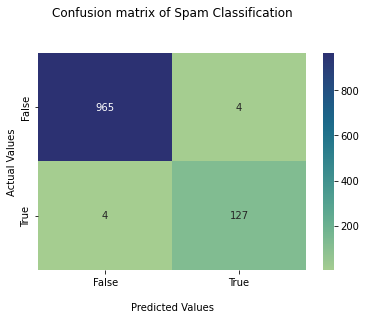

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# create a heatmap of the confusion matrix
ax = sns.heatmap(confusion_mx, annot=True, cmap='crest', fmt='g')


ax.set_title('Confusion matrix of Spam Classification\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');

# create tick labels
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


plt.show()

## Results

The BERT model has been fine tuned on the sms spam dataset and has returned an accuracy of 99% for this spam classification task. The presence of slang and abbreviated text language did not cause any issues for the robust BERT model and shows the ability to apply the model across a variety of tasks. There were 4 False positive and 4 false negatives out of the 1,100 samples in the test set indicating an equal performance of the model across both type 1 and type 2 errors.